In [10]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import pyro
import pyro.distributions as dist
from pyro.infer.autoguide import AutoDiagonalNormal
from pyro.infer import SVI, TraceEnum_ELBO, config_enumerate
from pyro.infer import Predictive

In [11]:
data = pd.read_csv('loan_timing.csv')
data = data.rename(columns={'days since origination': 'd_origin', 'days from origination to chargeoff': 'd_chargeoff'})
d_origin_np = data['d_origin'].to_numpy()
data_clean = data.dropna() 
d_chargeoff_np = data_clean['d_chargeoff'].to_numpy()
chargeoff = []
total = []
for i in range(np.max(d_origin_np)):
    temp_chargeoff = np.where(d_chargeoff_np == i)
    temp_total = np.where(d_origin_np == i)
    chargeoff.append(np.size(temp_chargeoff[0]))
    total.append(np.size(temp_total[0]))

In [12]:
total = np.asarray(total)
chargeoff = np.asarray(chargeoff)
percentage = chargeoff*100/50000
percentage_cumsum_np = np.cumsum(percentage)/100

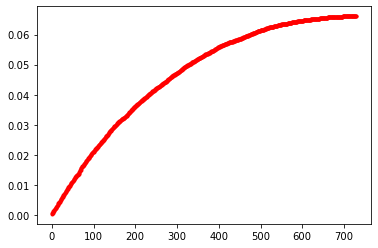

In [13]:
plt.plot(percentage_cumsum_np,'r.')

In [14]:
percentage_cumsum = torch.tensor(percentage_cumsum_np, dtype=torch.float)
time = torch.arange(np.size(percentage_cumsum_np))/1095.
time = time.type(torch.FloatTensor)
pyro.set_rng_seed(1)

In [15]:
def model(time, percentage_cumsum):
    L = pyro.sample("L", dist.Normal(0., 10.))
    k = pyro.sample("k", dist.Normal(0., 10.))
    z = pyro.sample("z", dist.Normal(0., 10.))
    sigma = pyro.sample("sigma", dist.Uniform(0., 10.))
    y = L*torch.exp(-k*torch.exp(-z*time))
    with pyro.plate("data", len(time)):
        pyro.sample("obs", dist.Normal(y, sigma), obs=percentage_cumsum)

In [16]:
guide = AutoDiagonalNormal(model)
adam = pyro.optim.Adam({"lr": 0.01})
svi = SVI(model, guide, adam, loss=TraceEnum_ELBO())
num_iters = 2000
pyro.clear_param_store()
losses = []
for i in range(num_iters):
    elbo = svi.step(time, percentage_cumsum)
    losses.append(elbo)
    print(elbo)

-2791.232666015625
-2812.079345703125
-2798.3515625
-2680.02978515625
-2850.5537109375
-2891.988525390625
-2529.665283203125
-2856.527587890625
-2885.220458984375
-2716.6630859375
-2734.32177734375
-2765.5771484375
-2867.277587890625
-2848.21875
-2863.719482421875
-2781.59619140625
-2892.660400390625
-2893.78564453125
-2834.601806640625
-2853.72802734375
-2855.255615234375
-2887.435791015625
-2879.70654296875
-2885.564208984375
-2860.905029296875
-2817.700439453125
-2883.89306640625
-2825.990966796875
-2896.20947265625
-2903.2626953125
-2879.750732421875
-2895.09814453125
-2828.356689453125
-2906.0693359375
-2692.271728515625
-2864.592529296875
-2904.68017578125
-2913.046630859375
-2814.095947265625
-2774.81298828125
-2888.621337890625
-2856.52001953125
-2867.43359375
-2850.85546875
-2865.662109375
-2869.596435546875
-2867.335205078125
-2834.830322265625
-2900.7685546875
-2861.01025390625
-2778.496826171875
-2888.2421875
-2917.56298828125
-2907.045166015625
-2878.262451171875
-2820.591

In [17]:
num_samples = 1000
predictive = Predictive(model, guide=guide, num_samples=num_samples)
pred = {k: v.reshape(num_samples).detach().cpu().numpy()
               for k, v in predictive(time, percentage_cumsum).items()
               if k != "obs"}
k = pred.get('k')
k_mean = np.mean(k, 0)
L = pred.get('L')
L_mean = np.mean(L, 0)
z = pred.get('z')
z_mean = np.mean(z, 0)

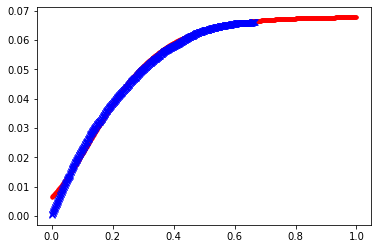

In [18]:
t = np.arange(1095)/1095.
y = L_mean*np.exp(-k_mean*np.exp(-z_mean*t))
plt.plot(t,y,'r.')
plt.plot(t[:730],percentage_cumsum_np,'bx')